In [10]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./model/shape_predictor_68_face_landmarks.dat')

[array([ 15.,  17., 245.]), array([ 13.,  22., 242.]), array([ 20.,  37., 246.]), array([ 18.,  70., 212.]), array([ 21.,  47., 231.]), array([ 15., 107., 157.]), array([ 11., 115., 126.]), array([  7., 107.,  93.]), array([13., 45., 40.]), array([13., 64., 56.])]


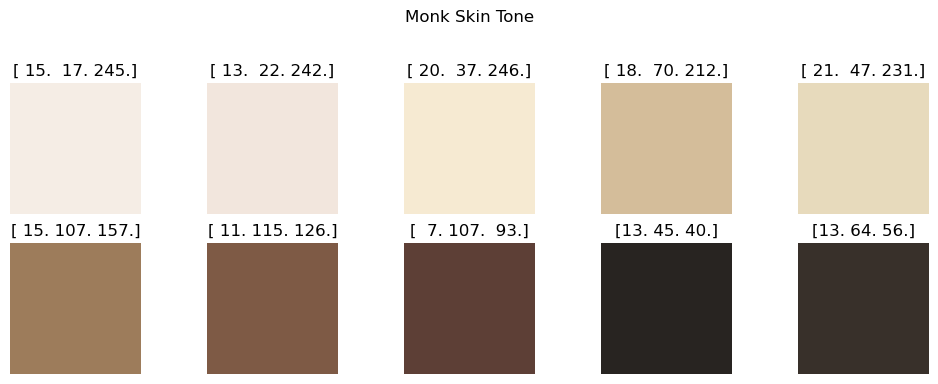

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the HEX colors
MONK_SKIN_TONE = ['#F5EDE5', '#F2E6DD', '#F6EAD2', '#D4BD9A', '#E7DABC', '#9D7C5B', '#7E5945', '#5D3F36', '#282421', '#38302A']

# Convert HEX to BGR and then to HSV
hsv_colors = []
for hex_color in MONK_SKIN_TONE:
    rgb_color = mcolors.hex2color(hex_color)  # Convert HEX to RGB
    bgr_color = rgb_color[::-1]  # Convert RGB to BGR
    bgr_array = np.full((100, 100, 3), bgr_color, dtype=np.float32) * 255  # Create a BGR NumPy array
    hsv_array = cv2.cvtColor(bgr_array.astype(np.uint8), cv2.COLOR_BGR2HSV)  # Convert BGR to HSV
    hsv_mean = np.mean(hsv_array, axis=(0, 1))  # Get the mean HSV value for plotting
    hsv_colors.append(hsv_mean)

print(hsv_colors)
# Plotting
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle('Monk Skin Tone')

for i, ax in enumerate(axs.flat):
    # Convert HSV back to BGR for plotting
    hsv_color = np.full((1, 1, 3), hsv_colors[i], dtype=np.uint8)
    bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)
    rgb_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    ax.imshow(rgb_color)
    ax.set_title(f'{hsv_colors[i]}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

(-0.5, 319.5, 319.5, -0.5)

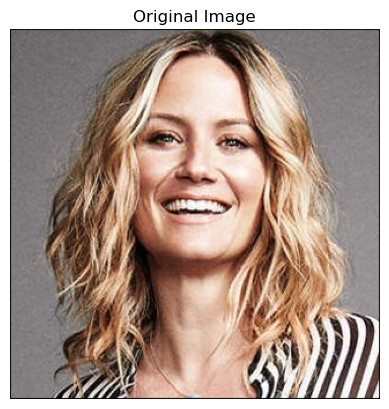

In [44]:
# Load the image
folder = 'Square'
name = 'square (19)'
image_path = f'./sample/{folder}/{name}.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

c:\Users\beeha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[208 165 146]
[249 197 175]


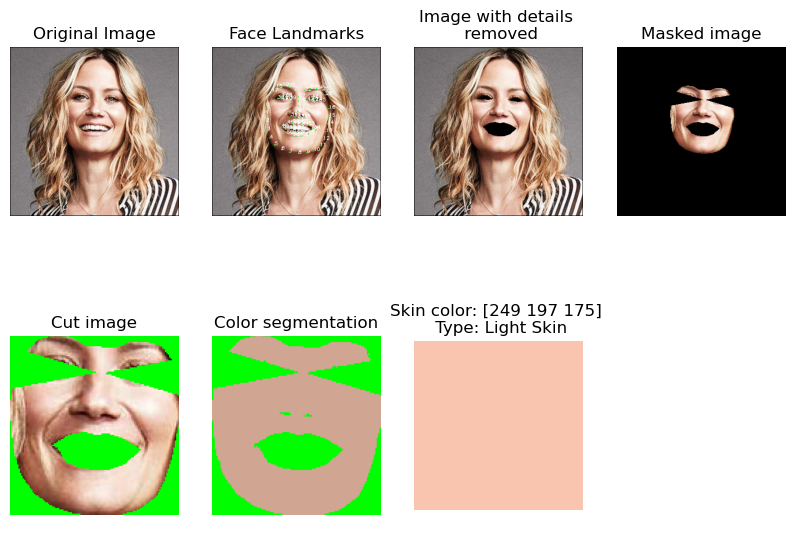

In [46]:
# Step 1: Identify face landmarks using dlib
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

fig, ax = plt.subplots(2, 4, figsize=(10, 7))
for row in ax:
    for col in row:
        col.axis('off')

if len(faces) > 0:
    face = faces[0]
    landmarks = predictor(gray, face)
    
    face_points = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)]
    # Plot the original image
    ax[0, 0].imshow(image_rgb)
    ax[0, 0].set_title("Original Image")
    
    # Find landmarks
    annotated_image = image_rgb.copy()
    for i, point in enumerate(face_points):
        cv2.circle(annotated_image, point, 1, (0, 255, 0), -1)
        # draw a point
        cv2.putText(annotated_image, str(i), (point[0], point[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
    ax[0, 1].imshow(annotated_image)
    ax[0, 1].set_title("Face Landmarks")
    
    # Step 2: create mask for details on face: eys and mouth
    lefteye_points = np.array(face_points[36:41], dtype=np.int32)
    righteye_points = np.array(face_points[42:47], dtype=np.int32)
    mouth_points = np.array(face_points[48:61], dtype=np.int32)
    cut_area = [lefteye_points, righteye_points, mouth_points]
    details_removed_image = image_rgb.copy()

    ## Step 3: cut the details
    for area in cut_area:
        mask = np.zeros(details_removed_image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [area], 255)
        mask = cv2.bitwise_not(mask)
        ax[1, 2].imshow(mask)
        details_removed_image = cv2.bitwise_and(details_removed_image, details_removed_image, mask=mask)

    ax[0, 2].imshow(details_removed_image)
    ax[0, 2].set_title("Image with details \n removed")

    mask = np.zeros(details_removed_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(face_points[:27], dtype=np.int32)], 255)
    masked_image = cv2.bitwise_and(details_removed_image, details_removed_image, mask=mask)
    ax[0, 3].imshow(masked_image)
    ax[0, 3].set_title("Masked image")


    # Step 4: Crop the face from the image
    y_values, x_values = np.where(mask == 255)
    x = min(x_values)
    y = min(y_values)
    w = max(x_values) - x
    h = max(y_values) - y
    cropped_face = masked_image[y:y+h, x:x+w]
    
    # Step 5: add green color to the background, prevent black color affect the kmeans results
    green_color = np.array([0, 255, 0], dtype=np.uint8)
    black_pixels_mask = np.all(cropped_face == [0, 0, 0], axis=-1)
    green_image = np.full(cropped_face.shape, green_color, dtype=np.uint8)
    cropped_face = np.where(black_pixels_mask[..., None], green_image, cropped_face)


    ax[1, 0].imshow(cropped_face)
    ax[1, 0].set_title("Cut image")

    # Step 6: Color segmentation
    pixels = np.float32(cropped_face.reshape(-1, 3))
    n_colors = 2
    kmeans = KMeans(n_clusters=n_colors)
    labels = kmeans.fit_predict(pixels)
    colors = kmeans.cluster_centers_.astype(int)


    segmented_image = colors[labels].reshape(cropped_face.shape).astype(np.uint8)
    dominant_colors = colors[np.unique(labels, return_counts=True)[1].argsort()[::-1]]
    dominant_color = next((color for color in dominant_colors if np.any(color != [0, 0, 0])), None)
    print(dominant_color)

    
    # Step 7: Detect skin tone based on V value of HSV

    dominant_color_hsv = cv2.cvtColor(np.uint8([[dominant_color]]), cv2.COLOR_BGR2HSV)[0][0]

    brightness = 1.2  # Adjust this value as needed
    dominant_color_hsv[2] = min(255, dominant_color_hsv[2] * brightness) # V value
    dominant_color = cv2.cvtColor(np.uint8([[dominant_color_hsv]]), cv2.COLOR_HSV2BGR)[0][0]

    # Determine the skin tone category based on the dominant color
    if dominant_color is not None and np.mean(dominant_color) > 150:
        skin_tone_category = "Light Skin"
    else:
        skin_tone_category = "Dark Skin"

    print(dominant_color)
    # Plot the result
    ax[1, 1].imshow(segmented_image)
    ax[1, 1].set_title(f"Color segmentation")

    # Plot the dominant color
    dominant_color_image = np.full((100, 100, 3), dominant_color, dtype=np.uint8)
    ax[1, 2].imshow(dominant_color_image)
    ax[1, 2].set_title(f"Skin color: {dominant_color} \n Type: {skin_tone_category}")
else:
    print("No face detected.")
    plt.show()
